# Model Optimization and Evaluation


## 1. Setup and Data Loading

In [97]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import sys

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Utils functions
import os
import sys

# Add the src directory to Python path to import our utils module
src_path = os.path.abspath("../../src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import feature engineering utilities from our custom module
from utils import (  # type: ignore
    confusion_matrix_analysis,
)

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)


# Styling
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📚 Libraries imported successfully!")
print(f"📍 Working directory: {os.getcwd()}")

📚 Libraries imported successfully!
📍 Working directory: /Users/xaviercoulon/Documents/OC/OC_P4_ESN_TechNova_Partners/notebooks/modeling


In [98]:
# Load preprocessed data
print("LOADING PREPROCESSED DATA:")
print("="*50)

# Define data paths
data_path = "../../data/processed"
X_file = os.path.join(data_path, "X_features.csv")
y_file = os.path.join(data_path, "y_target.csv")

# Load features and target
X = pd.read_csv(X_file)
y = pd.read_csv(y_file).squeeze()  # Convert to Series

print(f"✅ Features loaded: {X.shape}")
print(f"✅ Target loaded: {y.shape}")

print(f"\n📊 Dataset Summary:")
print(f"   Total samples: {len(X)}")
print(f"   Total features: {X.shape[1]}")
print(f"   Target variable: {y.name}")
print(f"   Target classes: {sorted(y.unique())}")
print(f"   Class distribution:")
for class_val in sorted(y.unique()):
    count = (y == class_val).sum()
    percentage = (count / len(y)) * 100
    print(f"     Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Data ready for modeling!")

LOADING PREPROCESSED DATA:
✅ Features loaded: (1470, 42)
✅ Target loaded: (1470,)

📊 Dataset Summary:
   Total samples: 1470
   Total features: 42
   Target variable: a_quitte_l_entreprise
   Target classes: [np.int64(0), np.int64(1)]
   Class distribution:
     Class 0: 1233 (83.9%)
     Class 1: 237 (16.1%)

🎯 Data ready for modeling!


In [99]:
X.columns.tolist()

['age',
 'genre',
 'revenu_mensuel',
 'nombre_experiences_precedentes',
 'annee_experience_totale',
 'annees_dans_l_entreprise',
 'annees_dans_le_poste_actuel',
 'satisfaction_employee_environnement',
 'niveau_hierarchique_poste',
 'satisfaction_employee_nature_travail',
 'satisfaction_employee_equipe',
 'satisfaction_employee_equilibre_pro_perso',
 'note_evaluation_actuelle',
 'heure_supplementaires',
 'augementation_salaire_precedente',
 'nombre_participation_pee',
 'nb_formations_suivies',
 'distance_domicile_travail',
 'niveau_education',
 'frequence_deplacement',
 'annees_depuis_la_derniere_promotion',
 'annes_sous_responsable_actuel',
 'departement_Consulting',
 'departement_Ressources Humaines',
 'statut_marital_Divorcé(e)',
 'statut_marital_Marié(e)',
 'poste_Cadre Commercial',
 'poste_Consultant',
 'poste_Directeur Technique',
 'poste_Manager',
 'poste_Représentant Commercial',
 'poste_Ressources Humaines',
 'poste_Senior Manager',
 'poste_Tech Lead',
 'domaine_etude_Entrepreu

## 2. Train/Test Split

In [100]:
# Create train/test split
print("TRAIN/TEST SPLIT:")
print("="*50)

# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"✅ Train set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")

print(f"\n📊 Class distribution after split:")
print(f"\nTraining set:")
for class_val in sorted(y_train.unique()):
    count = (y_train == class_val).sum()
    percentage = (count / len(y_train)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\nTest set:")
for class_val in sorted(y_test.unique()):
    count = (y_test == class_val).sum()
    percentage = (count / len(y_test)) * 100
    print(f"  Class {class_val}: {count} ({percentage:.1f}%)")

print(f"\n🎯 Stratified split completed!")

TRAIN/TEST SPLIT:
✅ Train set: (1176, 42)
✅ Test set: (294, 42)

📊 Class distribution after split:

Training set:
  Class 0: 986 (83.8%)
  Class 1: 190 (16.2%)

Test set:
  Class 0: 247 (84.0%)
  Class 1: 47 (16.0%)

🎯 Stratified split completed!


In [101]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ================================
# Create Pipeline and CV Strategy
# ================================
# Create a pipeline with RandomForest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ================================
# Paramètres à tester pour GridSearch
# ================================
param_grid = {
    "rf__n_estimators": [200, 300, 400],
    "rf__max_depth": [6, 7, 8],
    "rf__min_samples_split": [4, 8, 12],
    "rf__min_samples_leaf": [2, 4, 6],
    "rf__max_features": ["sqrt", "log2"],
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

print("🔍 GridSearchCV Configuration:")
print(f"   Pipeline steps: {list(pipeline.named_steps.keys())}")
print(f"   CV strategy: {cv}")
print(f"   Parameter combinations: {len(list(ParameterGrid(param_grid)))}")
print(f"   Scoring metric: recall")

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall", 
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

print("\n🚀 Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

print("✅ Meilleurs paramètres trouvés :")
print(grid_search.best_params_)
print(f"Meilleur Recall (CV): {grid_search.best_score_:.4f}")

print(f"\n📋 GridSearchCV terminé. Évaluation finale avec seuil optimal dans la cellule suivante...")

🔍 GridSearchCV Configuration:
   Pipeline steps: ['smote', 'rf']
   CV strategy: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
   Parameter combinations: 486
   Scoring metric: recall

🚀 Starting GridSearchCV...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
✅ Meilleurs paramètres trouvés :
{'rf__class_weight': None, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 12, 'rf__n_estimators': 300}
Meilleur Recall (CV): 0.4421

📋 GridSearchCV terminé. Évaluation finale avec seuil optimal dans la cellule suivante...
✅ Meilleurs paramètres trouvés :
{'rf__class_weight': None, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 12, 'rf__n_estimators': 300}
Meilleur Recall (CV): 0.4421

📋 GridSearchCV terminé. Évaluation finale avec seuil optimal dans la cellule suivante...


🔹 Optimal threshold: 0.089


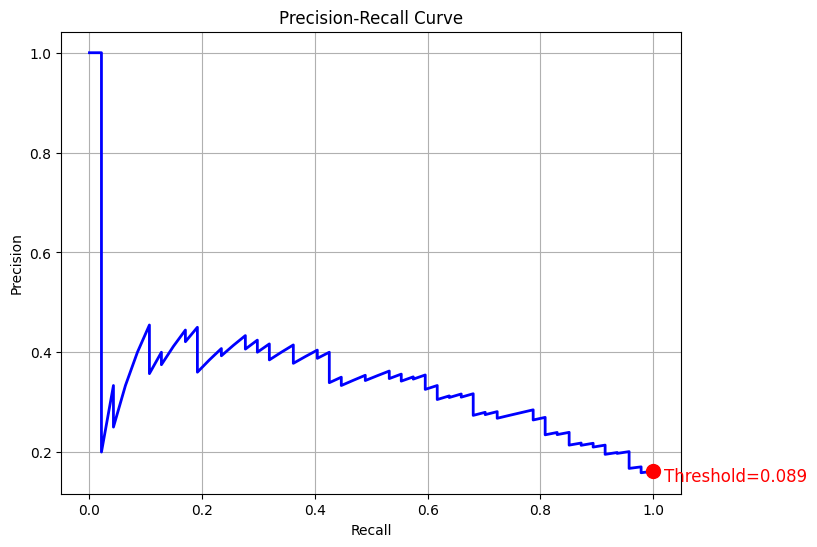


📊 Test Set Performance (avec seuil choisi):
Accuracy : 0.1769
Precision: 0.7457
Recall   : 0.1769
F1-Score : 0.0837


In [102]:
# =======================
# SEUIL OPTIMAL + ÉVALUATION FINALE
# =======================
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Probabilités sur l'ensemble de test avec le meilleur modèle
y_proba_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # classe 1

# Génération de la courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)

# Logique simple pour choisir un seuil "optimal"
# Exemple : maximiser recall tout en gardant une précision acceptable
optimal_idx = np.argmax(recall - (1 - precision))  # tu peux adapter selon ton objectif
optimal_threshold = thresholds[optimal_idx]
print(f"🔹 Optimal threshold: {optimal_threshold:.3f}")

# Visualiser la courbe Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2)

# Marquer le point du seuil optimal
plt.scatter(recall[optimal_idx], precision[optimal_idx], color="red", s=100, zorder=5)
plt.text(
    recall[optimal_idx] + 0.02,
    precision[optimal_idx] - 0.02,
    f"Threshold={optimal_threshold:.3f}",
    color="red",
    fontsize=12,
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# Appliquer le seuil pour créer les prédictions finales
y_pred_final = (y_proba_test >= 0.1).astype(int)

# Évaluation finale sur le test set
accuracy_test = accuracy_score(y_test, y_pred_final)
precision_test = precision_score(y_test, y_pred_final, average="weighted", zero_division=0)
recall_test = recall_score(y_test, y_pred_final, average="weighted")
f1_test = f1_score(y_test, y_pred_final, average="weighted")

print(f"\n📊 Test Set Performance (avec seuil choisi):")
print(f"Accuracy : {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall   : {recall_test:.4f}")
print(f"F1-Score : {f1_test:.4f}")

📋 Classification Report:


              precision    recall  f1-score   support

           0       0.86      0.02      0.05       247
           1       0.16      0.98      0.28        47

    accuracy                           0.18       294
   macro avg       0.51      0.50      0.16       294
weighted avg       0.75      0.18      0.08       294


=== CONFUSION MATRIX ANALYSIS for Random Forest Optimisé ===
📊 Confusion Matrix:
   True labels (rows) vs Predicted labels (columns)
   Classes: [np.int64(0), np.int64(1)]

[[  6 241]
 [  1  46]]


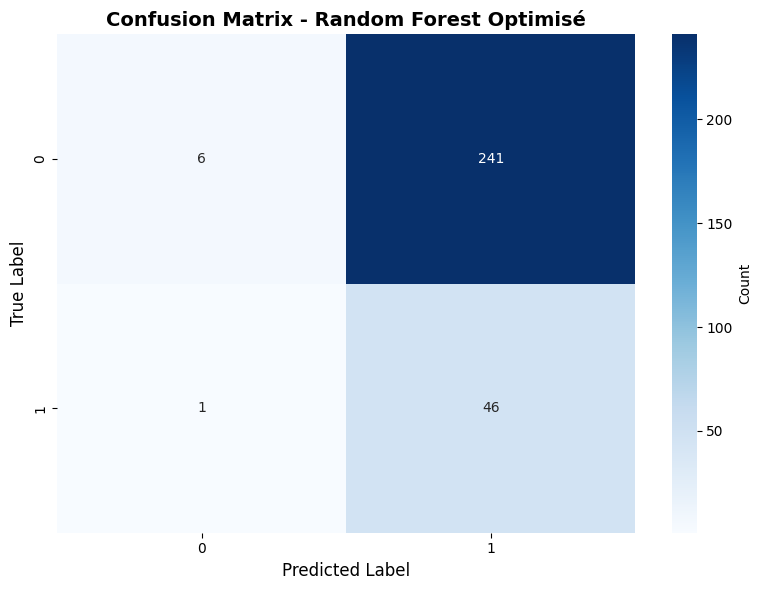


📈 Confusion Matrix Analysis:

   Class 0:
     True Positives:  6
     False Positives: 1
     False Negatives: 241
     True Negatives:  46
     Sensitivity (Recall): 0.0243
     Specificity:          0.9787
     Precision:            0.8571

   Class 1:
     True Positives:  46
     False Positives: 241
     False Negatives: 1
     True Negatives:  6
     Sensitivity (Recall): 0.9787
     Specificity:          0.0243
     Precision:            0.1603

🎯 Confusion Matrix completed!


In [103]:
# =======================
# RAPPORT DÉTAILLÉ DU MODÈLE
# =======================
from sklearn.metrics import classification_report

# Classification report détaillé
print("📋 Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_final))

# Confusion matrix avec visualisation
confusion_matrix_analysis(
    y_test, y_pred_final, model_name="Random Forest Optimisé"
)


🔍 Top 10 Most Important Features:
    1. nombre_participation_pee  : 0.0996
    2. statut_marital_Marié(e)   : 0.0863
    3. ratio_anciennete          : 0.0715
    4. satisfaction_employee_nature_travail : 0.0685
    5. satisfaction_employee_environnement : 0.0530
    6. revenu_mensuel            : 0.0515
    7. departement_Consulting    : 0.0476
    8. statut_marital_Divorcé(e) : 0.0447
    9. age                       : 0.0441
   10. annes_sous_responsable_actuel : 0.0439

📊 Feature Importance Visualization:


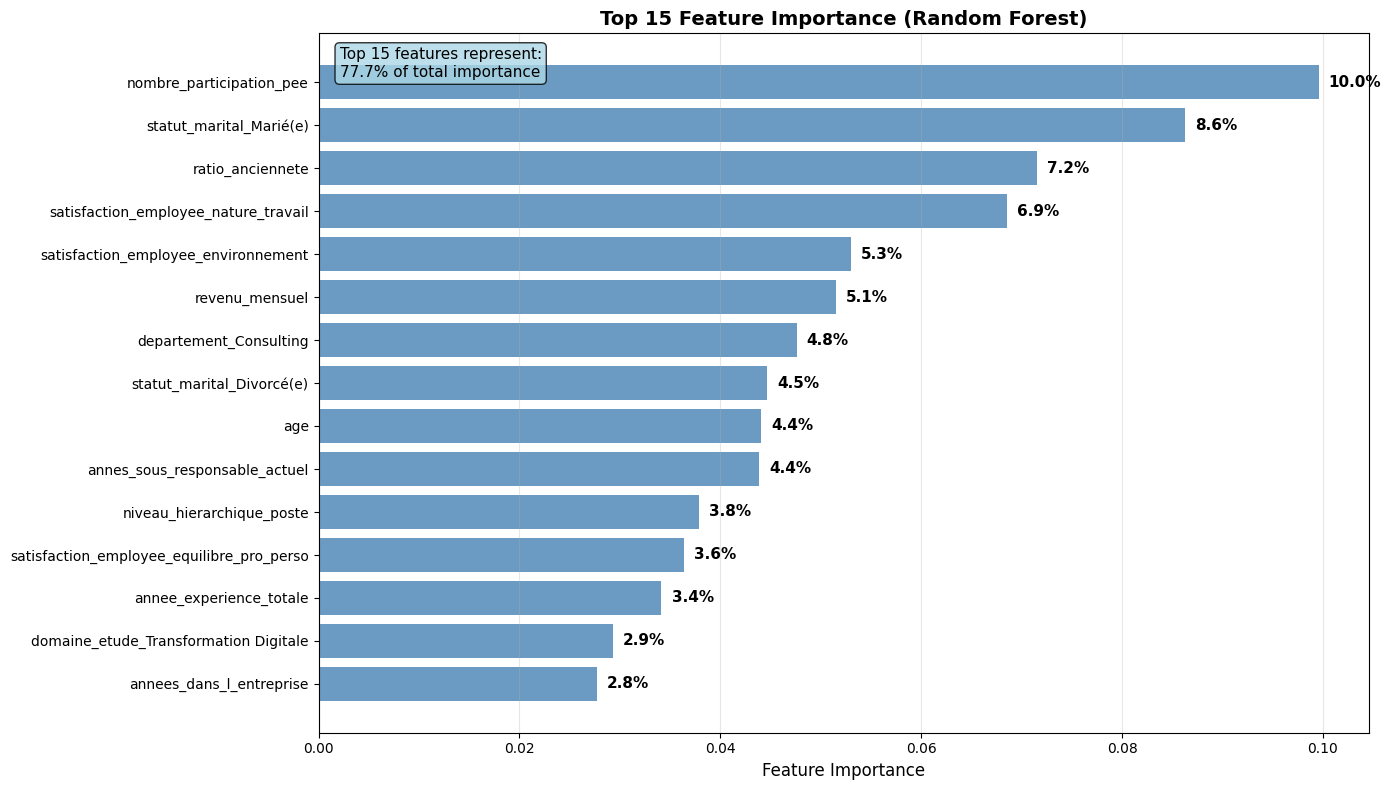


📈 Feature Importance Summary:
   Top 15 features contribute: 77.7% of total importance
   Top 5 features contribute: 38.0% of total importance
   Most important feature: nombre_participation_pee (10.0%)


In [104]:
# Feature importance
feature_importance = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": grid_search.best_estimator_.named_steps[
            "rf"
        ].feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\n🔍 Top 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:<25} : {row['importance']:.4f}")

# ================================
# FEATURE IMPORTANCE VISUALIZATION
# ================================
print("\n📊 Feature Importance Visualization:")

# Calculate percentages
top_features = feature_importance.head(15)
top_features_percentage = (top_features['importance'] * 100).round(1)

# Simple horizontal bar chart
plt.figure(figsize=(14, 8))

# Create horizontal bar chart
bars = plt.barh(range(len(top_features)), top_features['importance'], 
                color='steelblue', alpha=0.8)

# Customize the chart
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars with percentages only
for i, (bar, percentage) in enumerate(zip(bars, top_features_percentage)):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{percentage}%', va='center', fontsize=11, fontweight='bold')

# Add cumulative percentage text box
cumulative_percentage = top_features_percentage.sum()
textstr = f'Top 15 features represent:\n{cumulative_percentage:.1f}% of total importance'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

# Invert y-axis to have most important at top
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📈 Feature Importance Summary:")
print(f"   Top 15 features contribute: {cumulative_percentage:.1f}% of total importance")
print(f"   Top 5 features contribute: {top_features_percentage.head(5).sum():.1f}% of total importance")
print(f"   Most important feature: {top_features.iloc[0]['feature']} ({top_features_percentage.iloc[0]:.1f}%)")

## 3. Model Explainability with SHAP

Understanding model predictions through SHAP (SHapley Additive exPlanations) analysis.

🔍 Initializing SHAP TreeExplainer...

📊 Calculating SHAP values for test set...
✅ SHAP values calculated for 100 samples
📐 SHAP values shape: (100, 42, 2)
📐 Final SHAP values shape: (100, 42)
🎯 Expected value: 0.5011

📈 1. SHAP Summary Plot (Global Importance):
📊 Calculating SHAP values for test set...
✅ SHAP values calculated for 100 samples
📐 SHAP values shape: (100, 42, 2)
📐 Final SHAP values shape: (100, 42)
🎯 Expected value: 0.5011

📈 1. SHAP Summary Plot (Global Importance):


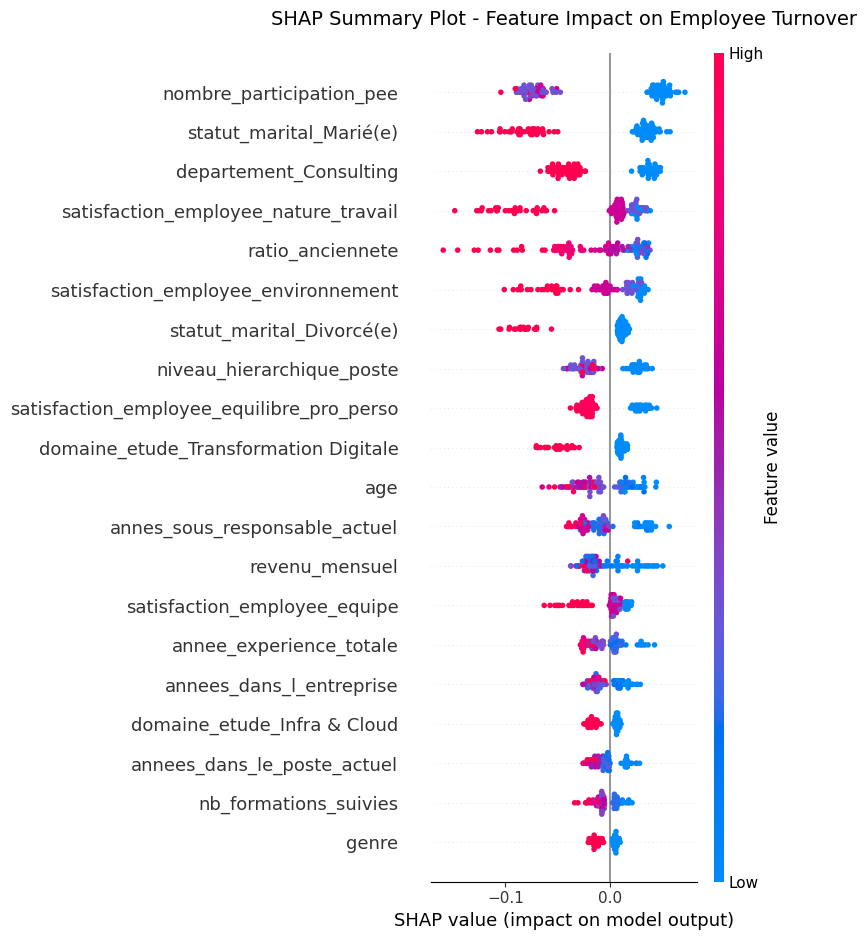


📊 2. SHAP Feature Importance (Mean Absolute Values):


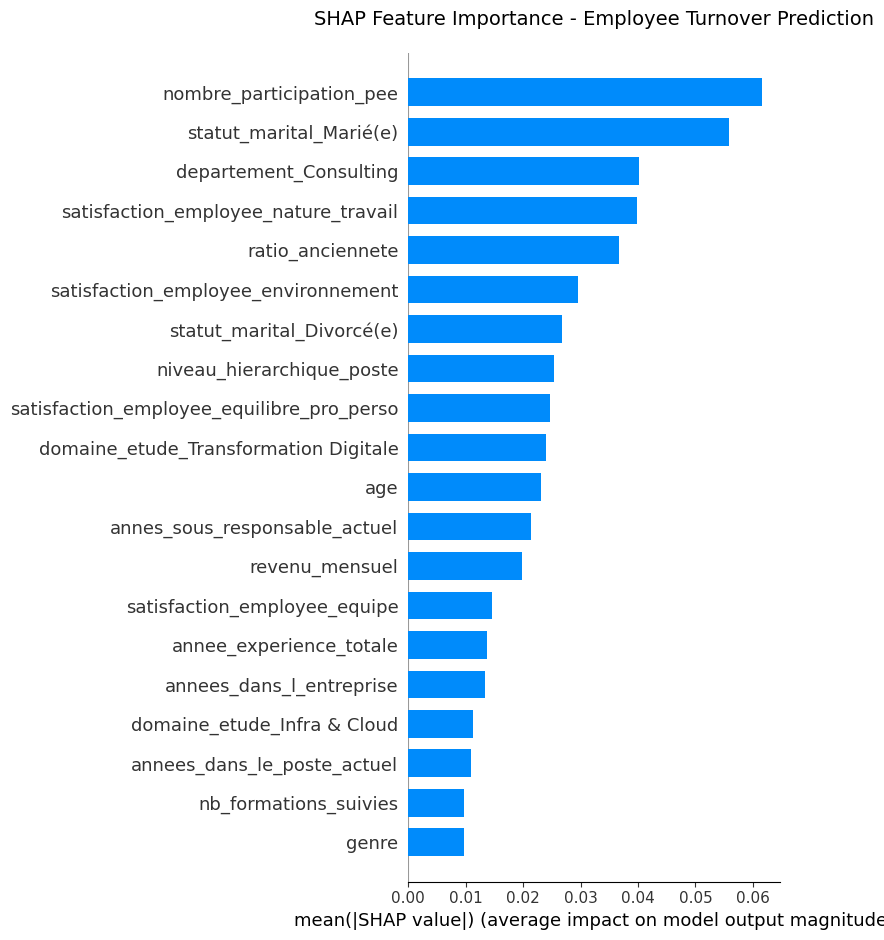


💧 3. SHAP Waterfall Plot (Individual Prediction Example):


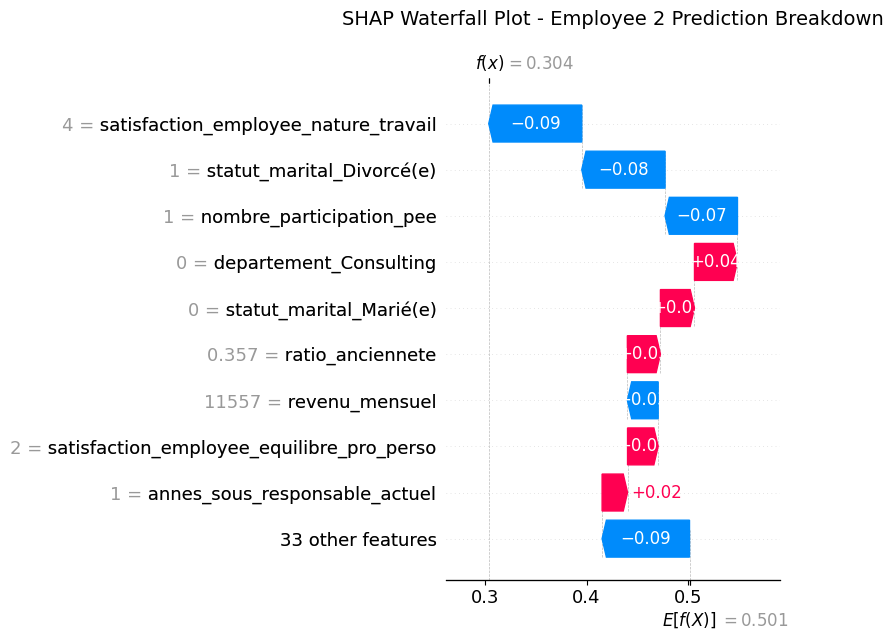


🎯 4. SHAP Insights Summary:
🔍 Top 10 Most Influential Features (SHAP):
    1. nombre_participation_pee  : 0.0616
    2. statut_marital_Marié(e)   : 0.0558
    3. departement_Consulting    : 0.0402
    4. satisfaction_employee_nature_travail : 0.0398
    5. ratio_anciennete          : 0.0367
    6. satisfaction_employee_environnement : 0.0296
    7. statut_marital_Divorcé(e) : 0.0268
    8. niveau_hierarchique_poste : 0.0254
    9. satisfaction_employee_equilibre_pro_perso : 0.0246
   10. domaine_etude_Transformation Digitale : 0.0240

📋 SHAP vs Random Forest Importance Comparison:
------------------------------------------------------------
Top 5 Features Comparison:
Rank  SHAP Feature              RF Feature               
------------------------------------------------------------
1     nombre_participation_pee  nombre_participation_pee 
2     statut_marital_Marié(e)   statut_marital_Marié(e)  
3     departement_Consulting    ratio_anciennete         
4     satisfaction_employee_na

In [105]:
# =======================
# SHAP ANALYSIS - MODEL EXPLAINABILITY
# =======================

# Initialize SHAP explainer for RandomForest
print("🔍 Initializing SHAP TreeExplainer...")
rf_model = grid_search.best_estimator_.named_steps['rf']
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for test set (use subset for performance)
print("📊 Calculating SHAP values for test set...")
n_samples_shap = min(100, len(X_test))  # Limit to 100 samples for performance
X_test_sample = X_test.iloc[:n_samples_shap]
shap_values = explainer.shap_values(X_test_sample)

print(f"✅ SHAP values calculated for {n_samples_shap} samples")
print(f"📐 SHAP values shape: {shap_values.shape if not isinstance(shap_values, list) else [sv.shape for sv in shap_values]}")

# Handle different SHAP output formats
if isinstance(shap_values, list):
    # Multi-class case: take class 1 (employees who left)
    shap_values_class1 = shap_values[1]
    expected_value = float(explainer.expected_value[1])
else:
    # Check if shap_values has 3 dimensions (samples, features, classes)
    if len(shap_values.shape) == 3:
        # Take the second class (class 1 - employees who left)
        shap_values_class1 = shap_values[:, :, 1]
        expected_value = float(explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value)
    else:
        # Binary case: shap_values is already for positive class
        shap_values_class1 = shap_values
        expected_value = float(explainer.expected_value if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value)

print(f"📐 Final SHAP values shape: {shap_values_class1.shape}")
print(f"🎯 Expected value: {expected_value:.4f}")

# 1. Summary Plot - Global feature importance
print("\n📈 1. SHAP Summary Plot (Global Importance):")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Employee Turnover", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 2. Feature Importance Bar Plot
print("\n📊 2. SHAP Feature Importance (Mean Absolute Values):")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Employee Turnover Prediction", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 3. Waterfall plot for first prediction
print("\n💧 3. SHAP Waterfall Plot (Individual Prediction Example):")
example_idx = 2

try:
    # Create SHAP Explanation object for waterfall plot
    explanation = shap.Explanation(
        values=shap_values_class1[example_idx], 
        base_values=expected_value, 
        data=X_test_sample.iloc[example_idx].values,
        feature_names=X_test_sample.columns.tolist()
    )
    
    # Create waterfall plot
    plt.figure(figsize=(12, 8))
    shap.plots.waterfall(explanation, show=False)
    plt.title(f"SHAP Waterfall Plot - Employee {example_idx} Prediction Breakdown", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"⚠️ Waterfall plot not available: {e}")
    # Alternative: show values as text
    print("Individual prediction breakdown:")
    shap_values_single = shap_values_class1[example_idx]
    
    # Create feature-value pairs and sort by absolute importance
    feature_contributions = []
    for feature, value in zip(X_test_sample.columns, shap_values_single):
        # Convert to float safely
        if isinstance(value, np.ndarray):
            actual_value = float(value.item() if value.size == 1 else np.mean(value))
        else:
            actual_value = float(value)
        
        if abs(actual_value) > 0.01:  # Only show significant contributions
            feature_contributions.append((feature, actual_value))
    
    # Sort by absolute contribution
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(f"   Base value: {expected_value:.4f}")
    for feature, value in feature_contributions[:10]:  # Show top 10
        direction = "increases" if value > 0 else "decreases"
        print(f"   {feature:<25}: {value:+.4f} ({direction} turnover probability)")

# 4. Top SHAP feature insights
print("\n🎯 4. SHAP Insights Summary:")
print("="*60)

# Calculate mean absolute SHAP values for feature ranking
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
feature_importance_shap = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("🔍 Top 10 Most Influential Features (SHAP):")
for i, (_, row) in enumerate(feature_importance_shap.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['feature']:<25} : {row['mean_abs_shap']:.4f}")

# Compare with Random Forest feature importance
print("\n📋 SHAP vs Random Forest Importance Comparison:")
print("-" * 60)
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_model.feature_importances_
}).sort_values('rf_importance', ascending=False)

# Top 5 comparison
print("Top 5 Features Comparison:")
print(f"{'Rank':<5} {'SHAP Feature':<25} {'RF Feature':<25}")
print("-" * 60)
for i in range(5):
    shap_feat = feature_importance_shap.iloc[i]['feature']
    rf_feat = rf_importance.iloc[i]['feature']
    print(f"{i+1:<5} {shap_feat:<25} {rf_feat:<25}")

print(f"\n✅ SHAP Analysis Complete!")
print("💡 Key Insights:")
print("   - SHAP values show individual prediction contributions")
print("   - Red dots = increase probability of leaving")
print("   - Blue dots = decrease probability of leaving") 
print("   - Use these insights to understand model decisions and improve retention strategies")

🔹 Top examples pour Waterfall Plot:
Index 3 - Probabilité départ: 0.136, SHAP sum: -0.365
Index 28 - Probabilité départ: 0.129, SHAP sum: -0.372
Index 75 - Probabilité départ: 0.120, SHAP sum: -0.381
Index 76 - Probabilité départ: 0.104, SHAP sum: -0.397
Index 8 - Probabilité départ: 0.101, SHAP sum: -0.400


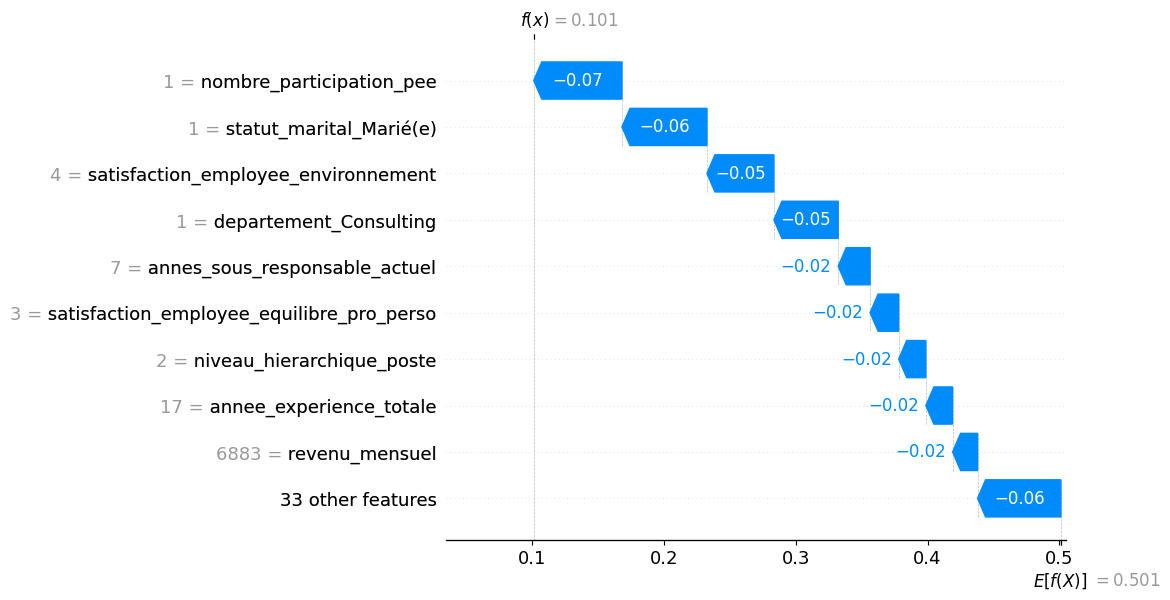

In [106]:
# 1. Calculer la distance entre la prédiction et la base value
shap_sum = shap_values_class1.sum(axis=1)  # somme des SHAP par observation
pred_diff = shap_sum  # distance à la valeur attendue (expected_value)
# Optionnel : on peut aussi regarder les extrêmes de probabilité
# pred_diff = y_proba_test - expected_value

# 2. Sélectionner les top N observations "intéressantes"
N = 5
top_indices = np.argsort(np.abs(pred_diff))[-N:]  # N plus impactantes

# 3. Afficher les indices et la probabilité
print("🔹 Top examples pour Waterfall Plot:")
for idx in top_indices:
    print(
        f"Index {idx} - Probabilité départ: {y_proba_test[idx]:.3f}, SHAP sum: {shap_sum[idx]:.3f}"
    )

# 4. Exemple pour tracer un waterfall sur le top 1
example_idx = top_indices[-1]

explanation = shap.Explanation(
    values=shap_values_class1[example_idx],
    base_values=expected_value,
    data=X_test_sample.iloc[example_idx].values,
    feature_names=X_test_sample.columns.tolist(),
)

shap.plots.waterfall(explanation)